In [197]:
from pathlib import Path

from pyaqua3ddev.image.image_processors.raw_processor import RawProcessor
from pyfishsensedev.image.pdf import Pdf
from pyfishsensedev.plane_detector.slate_detector import SlateDetector
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from pyfishsensedev.calibration.lens_calibration import LensCalibration
import torch
from pyfishsensedev.library.homography import viz2d
from pyfishsensedev.library.homography.utils import numpy_image_to_torch
from pyfishsensedev.library.homography.image_matcher import ImageMatcher
import cv2
import rawpy
from skimage.exposure import adjust_gamma, equalize_adapthist
from skimage.util import img_as_float, img_as_ubyte
import math

In [198]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [229]:
input_file = Path("./data/PC100114.ORF")
pdf_file = Path("./data/Dive Slate#1.pdf")
lens_calibration_file = Path("./data/fsl-05d-lens-raw.pkg")

input_file.exists(), pdf_file.exists(), lens_calibration_file.exists()

(True, True, True)

In [200]:
def imshow(image: np.ndarray, color="bgr"):
    image = img_as_ubyte(image)

    if image.ndim == 3:
        if color == "bgr":
            image = image[:, :, ::-1]

    plt.imshow(image)

In [238]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

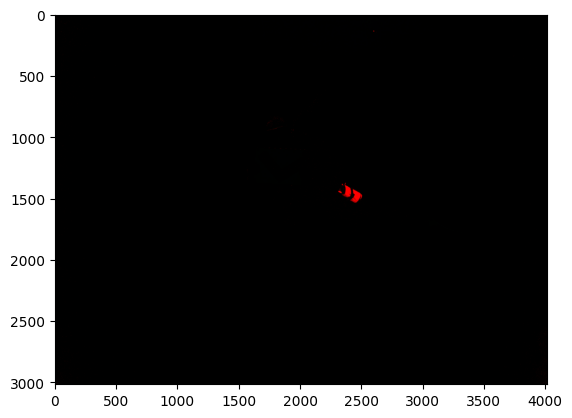

In [240]:
with rawpy.imread(input_file.as_posix()) as raw:
    img = img_as_float(
        raw.postprocess(
            gamma=(1, 1), no_auto_bright=True, use_camera_wb=False, output_bps=16
        )
    )

img = scale(gray_world(img))
hsv = cv2.cvtColor(img_as_ubyte(img), cv2.COLOR_BGR2HSV)
_, _, val = cv2.split(hsv)

mid = 20
mean = np.mean(val)
meanLog = math.log(mean)
midLog = math.log(mid * 255)
gamma = midLog / meanLog
gamma = 1 / gamma

# img = adjust_gamma(img, gamma=gamma)

# img = equalize_adapthist(img)

img = cv2.cvtColor(img_as_ubyte(img), cv2.COLOR_RGB2BGR)
imshow(img)

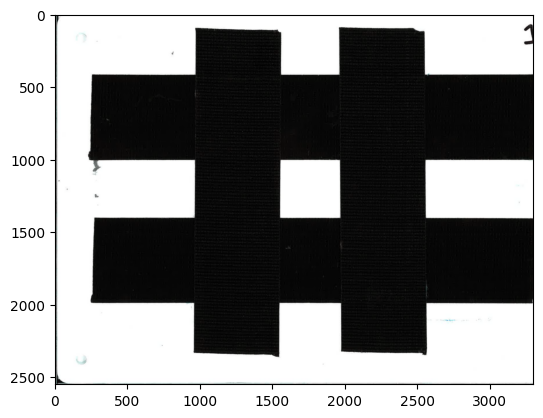

In [212]:
pdf = Pdf(pdf_file, rotation_degree=180)

imshow(pdf.image)

In [203]:
lens_calibration = LensCalibration()
lens_calibration.load(lens_calibration_file)

lens_calibration.camera_matrix

array([[2.83327797e+03, 0.00000000e+00, 2.00975722e+03],
       [0.00000000e+00, 2.85877370e+03, 1.40798662e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

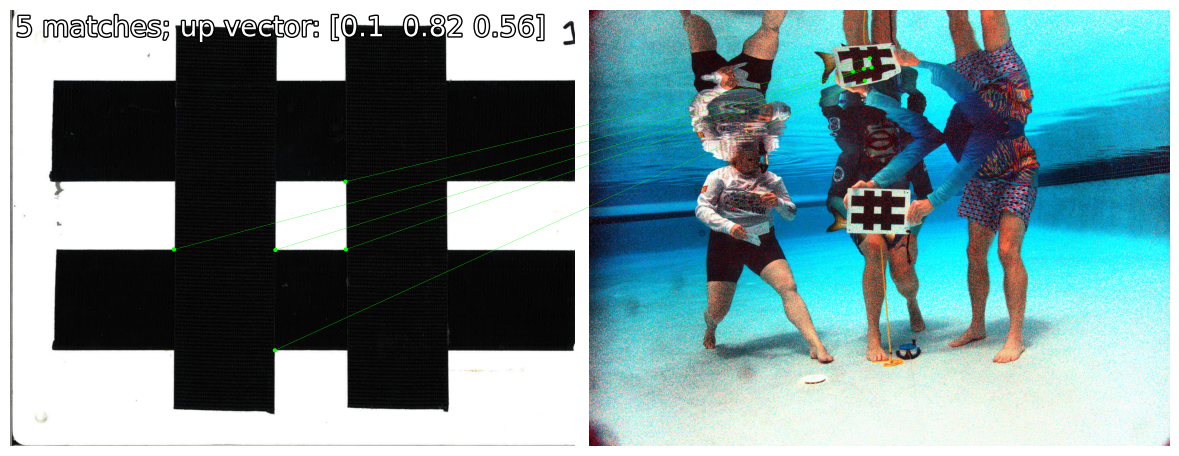

In [228]:
slate_detector = SlateDetector(img_as_ubyte(img), pdf, lens_calibration, device)
template_matches, image_matches = slate_detector._get_template_matches()

rotation, _ = slate_detector._get_body_to_camera_space_transform()

viz2d.plot_images([pdf.image, img[:, :, ::-1]])
viz2d.plot_matches(template_matches, image_matches, color="lime", lw=0.2)
viz2d.add_text(
    0,
    f"{len(template_matches)} matches; up vector: {np.round(rotation @ np.array([0, 1, 0]) * 100.0) / 100.0}",
    fs=20,
)
plt.show()